In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import arviz as az
import tensorflow_probability as tfp
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd

from zoobot.active_learning import acquisition_utils
from zoobot.active_learning.metrics import IterationState
from zoobot import label_metadata
from zoobot.estimators import losses, dirichlet_stats

In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


## Check hpd works

In [5]:
import scipy.stats

11 19
0.9012628532946048


(0, 30)

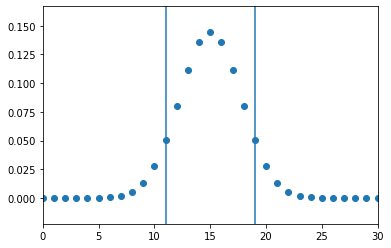

In [6]:
n = 30
k = np.arange(0, n+1)
p = 0.5
posterior = scipy.stats.binom.pmf(k, n, p)

(lower_lim, upper_lim), confidence, unimodal = dirichlet_stats.get_hpd(k, posterior, ci=.8)
print(lower_lim, upper_lim)
print(confidence)

plt.scatter(k, posterior)
plt.axvline(lower_lim)
plt.axvline(upper_lim)
plt.xlim(0, n)

In [7]:
posterior[lower_lim:upper_lim+1].sum()

0.9012628532946048

In [8]:
posterior[lower_lim:upper_lim].sum()

0.850387215614313

## Check coverage works

In [9]:
from scipy.stats import binom

In [10]:
n_galaxies = 500
num_answers = 10
x = np.arange(0., num_answers+1)  # zero
true_values = []
posteriors = []
for n in range(n_galaxies):
    p = np.random.rand()
    probs = binom(num_answers, p).pmf(x)
    posteriors.append((x, probs))
    true_values.append(binom.rvs(num_answers, p))

In [11]:
coverage = dirichlet_stats.get_coverage(posteriors, true_values)

In [12]:
coverage

,target_index,requested_ci_width_dont_use,confidence,lower_edge,upper_edge,true_value,true_within_hpd,unimodal
0,0,0.10,0.286924,8.0,8.0,7,False,True
1,1,0.10,0.248919,4.0,4.0,5,False,True
2,2,0.10,0.884919,0.0,0.0,0,True,True
3,3,0.10,0.514185,0.0,0.0,0,True,True
4,4,0.10,0.241886,5.0,5.0,5,True,True
...,...,...,...,...,...,...,...,...
24967,467,0.95,0.984460,5.0,10.0,8,True,True
24975,475,0.95,0.984117,5.0,10.0,6,True,True
24976,476,0.95,0.990261,0.0,3.0,0,True,True
24979,479,0.95,0.985610,5.0,10.0,7,True,True


In [13]:
# sns.set_context('talk')
# fig, ax = plt.subplots()

# plot_binned(coverage, label='Test')

# ax.plot([0., 1.], [0., 1.], 'k--')
# ax.set_xlim(0, 1.)
# ax.set_ylim(0, 1.)
# ax.set_ylabel('Ratio in interval')
# ax.set_xlabel('Credible interval width')
# ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.))
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.))
# ax.set_title(question.text.replace('-', ' ').title())
# fig.tight_layout()

## Use predictions

In [14]:

# state_loc = 'results/4q/latest_dirichlet_unfiltered_active_m3_warm/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_partial_label_cols
# questions = label_metadata.gz2_partial_questions



# state_loc = 'results/temp/gz2_all_q_warm_active/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions
# version = 'gz2'
# schema = losses.Schema(label_cols, questions, version=version)

# with open(state_loc, 'rb') as f:
#     state = pickle.load(f)

# samples_list = state.samples
# n_models = len(state.samples)
# state.samples[0].shape, state.acquisitions.shape, len(state.id_strs)

label_cols = label_metadata.decals_label_cols
questions = label_metadata.decals_questions
version = 'decals'
schema = losses.Schema(label_cols, questions, version=version)

# predictions_loc = 'results/temp/decals_n2_allq_m0_all.csv'
# eval_loc = 'results/temp/decals_n2_allq_m0_eval_shards/eval_df.csv'

eval_loc = 'results/decals_dr_full_eval_df.csv'
eval_df = pd.read_csv(eval_loc).sort_values('iauname').reset_index()

# one model, many dropout
# predictions_loc = 'results/decals_dr_full_m0_eval_predictions.csv'  # .1-20
# predictions = pd.read_csv(predictions_loc)

# samples = dirichlet_stats.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])
# samples_list = [samples]

# # many models, many dropout
predictions_locs = [
    'results/decals_dr_full_m0_eval_predictions.csv',
    'results/decals_dr_full_m1_eval_predictions.csv',
    'results/decals_dr_full_m2_eval_predictions.csv'
]
all_samples = []
for predictions_loc in predictions_locs:
    predictions = pd.read_csv(predictions_loc).sort_values('iauname').reset_index()
    assert all(predictions['iauname'] == eval_df['iauname'])
    all_samples.append(dirichlet_stats.load_all_concentrations(predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers]))
all_samples = np.concatenate(all_samples, axis=2)
print(all_samples.shape)

assert len(eval_df) == len(all_samples)



{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}
(49700, 34, 15)


In [15]:
eval_df['iauname']

0        J000001.55-000533.3
1        J000001.85+004309.3
2        J000002.29-042805.0
3        J000002.70+081756.0
4        J000006.63+004442.5
                ...         
49695    J235923.20+010820.9
49696    J235928.70+013500.0
49697    J235941.09-051613.8
49698    J235943.02+004227.3
49699    J235948.49-004607.8
Name: iauname, Length: 49700, dtype: object

In [16]:
predictions['iauname']

0        J000001.55-000533.3
1        J000001.85+004309.3
2        J000002.29-042805.0
3        J000002.70+081756.0
4        J000006.63+004442.5
                ...         
49695    J235923.20+010820.9
49696    J235928.70+013500.0
49697    J235941.09-051613.8
49698    J235943.02+004227.3
49699    J235948.49-004607.8
Name: iauname, Length: 49700, dtype: object

In [17]:
# n_samples = samples_list.shape[2]

In [18]:
# question = schema.get_question('smooth-or-featured')  # not binary any more!
question = schema.get_question('has-spiral-arms')
# question = schema.get_question('disk-edge-on')
# question = schema.get_question('bar')
answer = question.answers[0]
answer.text

'has-spiral-arms_yes'

In [19]:
# # apply a filter to eval_df and to samples
# is_featured = eval_df['smooth-or-featured_featured-or-disk_fraction'] > 0.5
# eval_df = eval_df[is_featured].reset_index()
# all_samples = all_samples[is_featured]
# len(eval_df), len(all_samples)

## Some basic checks to see if I can correctly find credible intervals

In [20]:
all_samples[1, question.start_index:question.end_index+1]

array([[ 1.73236871,  1.92396593,  2.19221926,  2.46112347,  2.19485617,
         2.1873529 ,  2.02861118,  2.42874908,  2.6538465 ,  2.5580101 ,
         1.71689355,  2.21185541,  1.92379689,  1.80206728,  1.88299227],
       [19.66293335, 16.92928886, 17.52332306, 15.99224186, 16.01057053,
        17.76146126, 16.12827682, 13.63426113, 14.63040924, 14.46552944,
        28.61507607, 23.55917358, 23.88155937, 24.00099373, 31.79277039]])

In [21]:
def get_coverage_data(samples, df, question, answer, n_galaxies):
    assert len(samples) == len(df)
    assert len(samples) >= n_galaxies
    id_strs = list(df['iauname']) # legacy, I assume df and samples are both sorted by iauname
    true_values = df[answer.text].values
    
    # (votes for zeroth answer, (p of votes per model))
    all_galaxy_posteriors = dirichlet_stats.get_posteriors(samples[:n_galaxies], df, id_strs, question, answer)  
    
    first_posteriors = [(votes, p_of_votes[0]) for votes, p_of_votes in all_galaxy_posteriors]  # first model and first dropout, they are concat if many models

    mean_posteriors = [(votes, p_of_votes.mean(axis=0)) for votes, p_of_votes in all_galaxy_posteriors]
    
    test_index = 0
#     print(all_galaxy_posteriors[test_index][1])
#     print(mean_posteriors[test_index][1])
    for p in all_galaxy_posteriors[test_index][1]:
        plt.plot(p, alpha=.3)
    plt.plot(mean_posteriors[test_index][1])
    plt.axvline(true_values[test_index])
    
    coverage_first = dirichlet_stats.get_coverage(first_posteriors, true_values)
    coverage_all = dirichlet_stats.get_coverage(mean_posteriors, true_values)
    
    return (first_posteriors, mean_posteriors), (coverage_first, coverage_all), true_values

In [22]:
disk = np.array(eval_df['disk-edge-on_no'] > 0.5)
spiral = np.array(eval_df['has-spiral-arms_yes'] > 0.5)
featured = np.array(eval_df['smooth-or-featured_featured-or-disk_fraction'] > 0.5)

In [23]:
eval_df[featured]['locations'].iloc[0]

'["https://panoptes-uploads.zooniverse.org/production/subject_location/9b8e52e2-122c-4f68-b0ab-42098d947d19.png", "https://panoptes-uploads.zooniverse.org/production/subject_location/9b8e52e2-122c-4f68-b0ab-42098d947d19.png"]'

In [24]:
eval_df[featured]['smooth-or-featured_featured-or-disk_fraction']

2        0.800000
5        0.600000
7        1.000000
8        0.600000
10       0.600000
           ...   
49689    0.555556
49691    0.600000
49692    0.600000
49693    0.800000
49696    1.000000
Name: smooth-or-featured_featured-or-disk_fraction, Length: 13829, dtype: float64

In [25]:
eval_df[featured]['disk-edge-on_no_fraction']

2        1.000000
5        0.666667
7        1.000000
8        1.000000
10       0.666667
           ...   
49689    0.400000
49691    1.000000
49692    1.000000
49693    1.000000
49696    0.000000
Name: disk-edge-on_no_fraction, Length: 13829, dtype: float64

In [26]:
answer

has-spiral-arms_yes, index 5

In [27]:
predictions['smooth-or-featured_smooth_concentration'][0]

'[100.02777099609375, 97.82882690429688, 93.5253677368164, 99.10511016845703, 98.50114440917969]'

In [28]:
# all_samples[0]

In [29]:
predictions[featured][['disk-edge-on_yes_concentration', 'disk-edge-on_no_concentration']]  # last 5 only

,disk-edge-on_yes_concentration,disk-edge-on_no_concentration
2,"[1.6704418659210205, 1.5056101083755493, 1.518...","[85.40021514892578, 86.37328338623047, 87.5264..."
5,"[10.476568222045898, 13.2660493850708, 10.6818...","[19.548341751098633, 15.24882698059082, 14.765..."
7,"[4.086644172668457, 4.091834545135498, 4.27661...","[84.64031982421875, 88.56946563720703, 89.9156..."
8,"[7.499283790588379, 6.787842273712158, 7.71753...","[92.62247467041016, 87.59896850585938, 92.9716..."
10,"[1.949257493019104, 3.583475112915039, 2.28213...","[76.83738708496094, 48.18535232543945, 77.3098..."
...,...,...
49689,"[13.5394287109375, 13.017696380615234, 17.6887...","[8.27752685546875, 9.687857627868652, 8.934642..."
49691,"[11.786920547485352, 12.340838432312012, 11.74...","[94.87384796142578, 95.27072143554688, 97.0742..."
49692,"[3.6933367252349854, 3.8627138137817383, 4.578...","[82.29533386230469, 75.79218292236328, 74.3439..."
49693,"[2.9183106422424316, 2.055495023727417, 2.3561...","[93.61643981933594, 98.97185516357422, 97.9350..."


In [30]:
all_samples[featured][0, question.start_index:question.end_index+1, 10:]

array([[36.76354218, 37.65036392, 38.57816315, 43.98692703, 31.98897934],
       [ 1.74843776,  1.7670188 ,  1.70662975,  1.6974647 ,  1.76423585]])

In [31]:
question, answer

(has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 has-spiral-arms_yes, index 5)

[0.] [1.]


IndexError: 

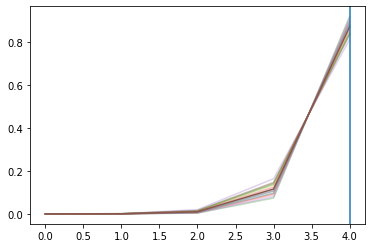

In [32]:
(first_posteriors, mean_posteriors), (coverage_first, coverage_all), true_values = get_coverage_data(
    all_samples[featured], eval_df[featured], question, answer, n_galaxies=500)

In [ ]:
coverage_first.query('target_index == 0')

In [ ]:
coverage_first['confidence'].hist()

In [ ]:
coverage_all['confidence'].hist()

In [ ]:
coverage_all['confidence_rounded'] = np.around(coverage_all['confidence'], 2)
temp = coverage_all.groupby('confidence_rounded').agg({'true_within_hpd': 'mean'}).reset_index()
plt.plot(temp['confidence_rounded'], temp['true_within_hpd'])
plt.plot([0, 1], [0, 1], color='k', linestyle='--')

In [ ]:
coverage_all.query('target_index == 1')

In [ ]:
# test_index = 1
# x, p = all_posteriors[test_index]
# for d in p:
#     plt.scatter(x, x, marker='+')
#     plt.axvline(true_values[test_index])

In [ ]:
p

In [ ]:
# (lower_edge, upper_edge), confidence, unimodal = dirichlet_stats.get_hpd(x, p, ci=.9)
# lower_edge, upper_edge, confidence

In [ ]:
# x, p = first_posteriors[0]
# for d in p:
#     plt.scatter(x, p, marker='+')
#     plt.axvline(true_values[0])

In [ ]:
# (lower_edge, upper_edge), confidence, unimodal = dirichlet_stats.get_hpd(x, p, ci=.9)
# lower_edge, upper_edge, confidence

In [ ]:
plt.scatter(x, p, marker='+')
plt.axvline(lower_edge)
plt.axvline(upper_edge)

In [ ]:
# sns.scatterplot(x=eval_predictions['has-spiral-arms_yes_fraction'], y=eval_predictions['has-spiral-arms_yes_concentration_mean']/(eval_predictions['has-spiral-arms_no_concentration_mean'] + eval_predictions['has-spiral-arms_yes_concentration_mean']), alpha=.01)

In [ ]:
# is_retired = eval_predictions['smooth-or-featured_total-votes'] > 36 
# retired = eval_predictions[is_retired]
# sns.scatterplot(x=retired['has-spiral-arms_yes_fraction'], y=retired['has-spiral-arms_yes_concentration_mean']/(retired['has-spiral-arms_no_concentration_mean'] + retired['has-spiral-arms_yes_concentration_mean']), alpha=.07)

## Now let's find coverage for various subsets

In [ ]:

# temp = 0.2
# tempered_posteriors = [(indices, (posterior ** temp) / np.sum(posterior ** temp)) for (indices, posterior) in first_posteriors]

# uniform_posteriors = [(indices, np.ones(len(indices)) / len(indices)) for (indices, posterior) in first_posteriors]

In [ ]:
# plt.plot(first_posteriors[0][0], first_posteriors[0][1], label='original')
# plt.plot(tempered_posteriors[0][0], tempered_posteriors[0][1], label='tempered')

In [ ]:

# coverage_tempered = dirichlet_stats.get_coverage(tempered_posteriors, true_values)
# coverage_uniform = dirichlet_stats.get_coverage(uniform_posteriors, true_values)

In [33]:
def plot_binned(coverage, label, n_bins=20, min_count=20, plt_kwargs={}):
    coverage['confidence_bin'], bins = pd.cut(coverage['confidence'], bins=n_bins, retbins=True)
    coverage['bin_center'] = coverage['confidence_bin'].apply(lambda interval: float(interval.mid))
    grouped_by_bin = coverage.groupby('bin_center').agg({'true_within_hpd': 'mean', 'confidence': 'count'}).reset_index()
    grouped_by_bin = grouped_by_bin.rename(columns={'confidence': 'count'})
    selected = grouped_by_bin.query(f'count > {min_count}')
#     print(coverage['confidence_bin'])
#     print(coverage['bin_center'].astype(float))
#     fig, ax = plt.subplots(figsize=figsize)
    plt.plot(selected['bin_center'].astype(float), selected['true_within_hpd'], label=label, marker='.', **plt_kwargs)

NameError: name 'coverage_first' is not defined

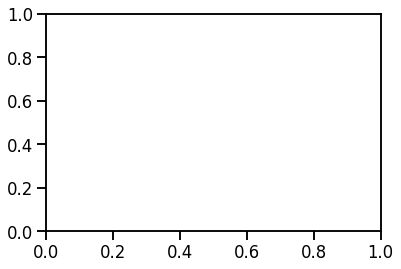

In [34]:
sns.set_context('talk')
fig, ax = plt.subplots()

plot_binned(coverage_first, label='One Model')
plot_binned(coverage_all, label='All Models')
# plot_binned(coverage_tempered, label='Tempered')
# plot_binned(coverage_uniform, label='Uniform')

ax.plot([0., 1.], [0., 1.], 'k--')
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.)
ax.set_ylabel('Ratio in interval')
ax.set_xlabel('Credible interval width')
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.set_title(question.text.replace('-', ' ').title())
fig.tight_layout()
# fig.savefig('calibration_single_model_' + question.text + '.pdf')

# I think I'm measuring wrong - how is a uniform posterior overconfident?!

In [35]:
n_galaxies = 1000

In [36]:
# # featured = eval_df['smooth-or-featured_featured-or-disk_fraction'] > 0.5
# more_than_10 = (eval_df['disk-edge-on_no'] > 10) & (eval_df['disk-edge-on_no'] <= 20)
# eval_df_10 = eval_df[more_than_10]
# samples_10 = all_samples[more_than_10]
# print(len(samples_10))
# (first_posteriors_10, mean_posteriors_10), (coverage_first_10, coverage_all_10), true_values_10 = get_coverage_data(samples_10, eval_df_10, question, answer, n_galaxies=n_galaxies)

In [46]:
# question = schema.get_question('disk-edge-on')
question = schema.get_question('has-spiral-arms')
answer = question.answers[0]

In [47]:
featured = eval_df['smooth-or-featured_featured-or-disk_fraction'] > 0.5  # already applied
not_disk = eval_df['disk-edge-on_no_fraction'] > 0.5

max_5_disk = (eval_df['disk-edge-on_no'] >= 3) & (eval_df['disk-edge-on_no'] <= 5)
max_5_featured = (eval_df['smooth-or-featured_total-votes'] >= 3) & (eval_df['smooth-or-featured_total-votes'] <= 5)

around_40_disk = (eval_df['disk-edge-on_no'] >= 30) & (eval_df['disk-edge-on_no'] <= 40)
around_40_featured = (eval_df['smooth-or-featured_total-votes'] >= 30) & (eval_df['smooth-or-featured_total-votes'] <= 40)

5960


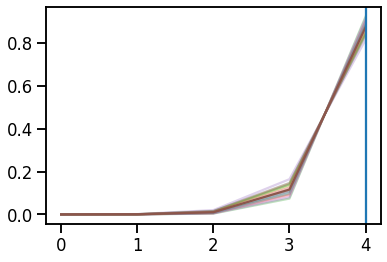

In [48]:

if question.text == 'disk-edge-on':
    eval_df_5 = eval_df[max_5_featured & featured]
    samples_5 = all_samples[max_5_featured & featured]
if question.text == 'has-spiral-arms':
    eval_df_5 = eval_df[max_5_disk & featured & not_disk]
    samples_5 = all_samples[max_5_disk & featured & not_disk]

print(len(samples_5))
n_galaxies = len(samples_5)
# n_galaxies = 100
(first_posteriors_5, mean_posteriors_5), (coverage_first_5, coverage_all_5), true_values_5 = get_coverage_data(samples_5, eval_df_5, question, answer, n_galaxies=n_galaxies)

In [49]:
unimodal = coverage_all_5['unimodal']
coverage_all_5 = coverage_all_5[unimodal]  # only ever multimodal in ensemble

1214


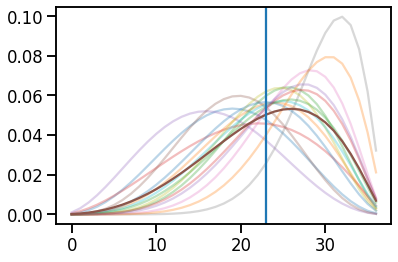

In [50]:


if question.text == 'disk-edge-on':
    eval_df_40 = eval_df[around_40_featured & featured]
    samples_40 = all_samples[around_40_featured & featured]
if question.text == 'has-spiral-arms':
    eval_df_40 = eval_df[around_40_disk & featured & not_disk]
    samples_40 = all_samples[around_40_disk & featured & not_disk]

print(len(samples_40))
# n_galaxies = 100
n_galaxies = len(samples_40)
(first_posteriors_40, mean_posteriors_40), (coverage_first_40, coverage_all_40), true_values_40 = get_coverage_data(samples_40, eval_df_40, question, answer, n_galaxies=n_galaxies)

In [51]:
unimodal = coverage_all_40['unimodal']
coverage_all_40 = coverage_all_40[unimodal]  # only ever multimodal in ensemble

In [52]:
# adding galaxies, calibration turning point changes: 40, 55, 60! 
# many fewer galaxies for high N
# need to address why this is happening (something with binning, I assume)
# run a simulation with few galaxies, and increase

In [53]:

# temp = 0.2
# tempered_posteriors = [(indices, (posterior ** temp) / np.sum(posterior ** temp)) for (indices, posterior) in mean_posteriors_40]
# coverage_40_t20 = dirichlet_stats.get_coverage(tempered_posteriors, true_values_40)


# temp = 0.2
# tempered_posteriors = [(indices, (posterior ** temp) / np.sum(posterior ** temp)) for (indices, posterior) in mean_posteriors_5]
# coverage_5_t20 = dirichlet_stats.get_coverage(tempered_posteriors, true_values_5)

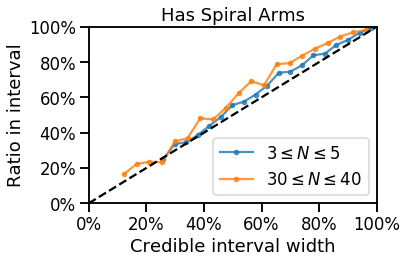

In [60]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=None)

min_count = 100

colors = sns.color_palette()
# plot_binned(coverage_first_5, label=None, plt_kwargs={'linestyle': 'dashed', 'color': colors[0], 'alpha': .8})
plot_binned(coverage_all_5, label=r'$3 \leq N \leq 5$', plt_kwargs={'linestyle': 'solid', 'color': colors[0], 'alpha': .8}, min_count=min_count)
# plot_binned(coverage_first_10, label='10-20')
# plot_binned(coverage_first_40, label=None, plt_kwargs={'linestyle': 'dashed', 'color': colors[1], 'alpha': .8})
plot_binned(coverage_all_40, label=r'$30 \leq N \leq 40$', plt_kwargs={'linestyle': 'solid', 'color': colors[1], 'alpha': .8}, min_count=min_count)


# plot_binned(coverage_all_10, label='All Models')
# plot_binned(coverage_tempered, label='Tempered')
# plot_binned(coverage_uniform, label='Uniform')

ax.plot([0., 1.], [0., 1.], 'k--')
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.)
ax.set_ylabel('Ratio in interval')
ax.set_xlabel('Credible interval width')
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.set_title(question.text.replace('-', ' ').title())
fig.tight_layout()
plt.legend()

# plt.savefig('spiral-arm-coverage.png')
# plt.savefig('spiral-arm-coverage.pdf')
plt.savefig('spiral-arm-coverage_all.png')
plt.savefig('spiral-arm-coverage_all.pdf')
# plt.savefig('disk-edge-on-coverage_all.png')
# plt.savefig('disk-edge-on-coverage_all.pdf')

In [ ]:
assert False

In [ ]:
# sns.set_context('talk')
# fig, ax = plt.subplots(figsize=(12, 8))

# plot_binned(coverage_5_t20, label='5 T20')
# plot_binned(coverage_40_t20, label='40 T20')

# ax.plot([0., 1.], [0., 1.], 'k--')
# ax.set_xlim(0, 1.)
# ax.set_ylim(0, 1.)
# ax.set_ylabel('Ratio in interval')
# ax.set_xlabel('Credible interval width')
# ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.))
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.))
# ax.set_title(question.text.replace('-', ' ').title())
# fig.tight_layout()


In [ ]:
assert False

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots()

plot_binned(coverage_first_5, label='<5')
# plot_binned(coverage_first_10, label='10-20')
plot_binned(coverage_first_40, label='30-50')

# plot_binned(coverage_all_10, label='All Models')
# plot_binned(coverage_tempered, label='Tempered')
# plot_binned(coverage_uniform, label='Uniform')

ax.plot([0., 1.], [0., 1.], 'k--')
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.)
ax.set_ylabel('Ratio in interval')
ax.set_xlabel('Credible interval width')
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.set_title(question.text.replace('-', ' ').title())
fig.tight_layout()

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots()

plot_binned(coverage_first_5, label='<5')
# plot_binned(coverage_first_10, label='10-20')
plot_binned(coverage_first_40, label='30-50')

# plot_binned(coverage_all_10, label='All Models')
# plot_binned(coverage_tempered, label='Tempered')
# plot_binned(coverage_uniform, label='Uniform')

ax.plot([0., 1.], [0., 1.], 'k--')
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.)
ax.set_ylabel('Ratio in interval')
ax.set_xlabel('Credible interval width')
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.set_title(question.text.replace('-', ' ').title())
fig.tight_layout()

In [ ]:
grouped_by_bin = coverage_all.groupby('bin_center').agg({'true_within_hpd': 'mean'}).reset_index()
sns.scatterplot(data=grouped_by_bin, x='bin_center', y='true_within_hpd')
plt.plot([0., 1.], [0., 1.], 'k--')
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.title(question.text)

In [ ]:
sns.lineplot(data=coverage_first, x='bin_center', y='true_within_hpd', ci=90)
sns.lineplot(data=coverage_all, x='bin_center', y='true_within_hpd', ci=90)
plt.plot([0., 1.], [0., 1.], 'k--')

In [ ]:
coverage_first.groupby('confidence_bin').agg({'true_within_hpd': 'mean'})

In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(data=coverage_first, x='bin_center', y='true_within_hpd', ax=ax, ci=90, label='First')
sns.lineplot(data=coverage_all, x='bin_center', y='true_within_hpd', ax=ax, ci=90, label='All')
ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()
# This the same as my manual version below
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

In [ ]:
top_acq = np.argsort(state.acquisitions) > (4 * len(state.acquisitions) / 5.)
print(top_acq.mean())

selector = top_acq
coverage_first = dirichlet_stats.get_coverage(
    [y for n, y in enumerate(first_posteriors) if selector[n]],
    [y for n, y in enumerate(true_values) if selector[n]]
)
coverage_all = dirichlet_stats.get_coverage(
    [y for n, y in enumerate(mean_posteriors) if selector[n]],
    [y for n, y in enumerate(true_values) if selector[n]]
)

fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(data=coverage_first, x='ci_width', y='true_within_hpd', ax=ax, ci=90, label='First')
sns.lineplot(data=coverage_all, x='ci_width', y='true_within_hpd', ax=ax, ci=90, label='All')
ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()
# This the same as my manual version below
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])